## Import external libraries. 

In [1]:
import  torch;
import  matplotlib.pyplot   as plt;
import  seaborn;
from    typing      import  List, Dict, Tuple;
import  numpy;

## Import my code

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `MODEL` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `MODEL` object. Recall that a `MODEL` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `MODEL`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

The Loss_Fn defines the loss we try to minimize. Currently, this is just the MSE between the predicted and target trajectory.

In [2]:
from    MODEL   import  MODEL;
from    Solver  import  RK2             as DDE_Solver;
from    NDDE    import  NDDE_1D;
from    Loss    import  SSE_Loss        as Loss_Fn;

### Generate True solution

Generate the true solution and plot it!

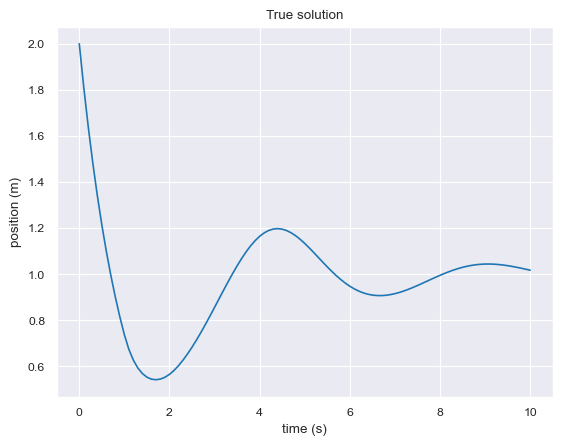

In [3]:
# Set up an object to represent the vector field that we want to learn
F_True          = MODEL(c_0 = 1.0, c_1 = 1.0);
x_0_True        = torch.tensor([2.0]);
tau_True        = torch.tensor(1.0);
T_True          = torch.tensor(10.0);
x_Trajectory_True, t_Trajectory_True  = DDE_Solver(F = F_True, x_0 = x_0_True, tau = tau_True, T = T_True);


# Now, plot the true trajectory.
seaborn.set_context(context     = "paper");
seaborn.set_style(  style       = "darkgrid");
palette : str = "winter";
seaborn.lineplot(x = t_Trajectory_True.detach().numpy(), y = x_Trajectory_True.reshape(-1).detach().numpy(), palette = palette);
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("True solution");

### Setup, train the Model 


   0:   Loss = 0.41480  | tau = 1.05000  | grad tau =   9.86918  | Params = 1.00000, 1.00000  | grad Params = -15.80874, -24.92489
   1:   Loss = 0.09131  | tau = 1.00965  | grad tau =   2.04328  | Params = 1.00000, 1.00000  | grad Params = -34.29607, -71.49443
   2:   Loss = 0.00332  | tau = 0.97853  | grad tau =  -0.02394  | Params = 1.00000, 1.00000  | grad Params = -38.73925, -83.60690
   3:   Loss = 0.01183  | tau = 0.95020  | grad tau =   1.03508  | Params = 1.00000, 1.00000  | grad Params = -28.45844, -54.20527
   4:   Loss = 0.06681  | tau = 0.91882  | grad tau =   3.39744  | Params = 1.00000, 1.00000  | grad Params =  -3.70130,  17.87768
   5:   Loss = 0.15817  | tau = 0.88174  | grad tau =   7.32992  | Params = 1.00000, 1.00000  | grad Params =  34.91576, 132.80006
   6:   Loss = 0.35426  | tau = 0.84127  | grad tau =  14.43268  | Params = 1.00000, 1.00000  | grad Params =  94.70651, 313.59662
   7:   Loss = 0.59377  | tau = 0.79935  | grad tau =  23.07075  | Params = 1.00000

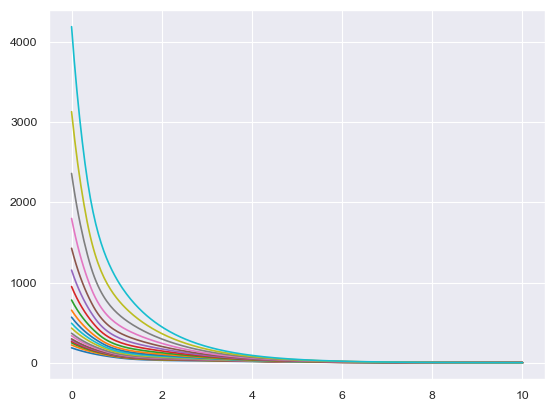

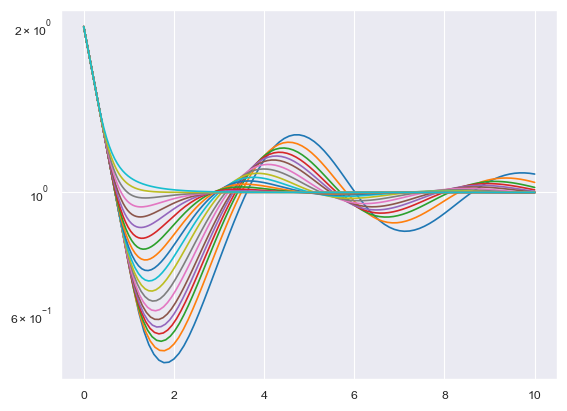

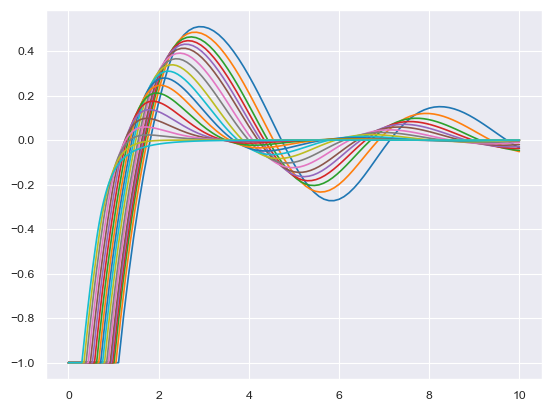

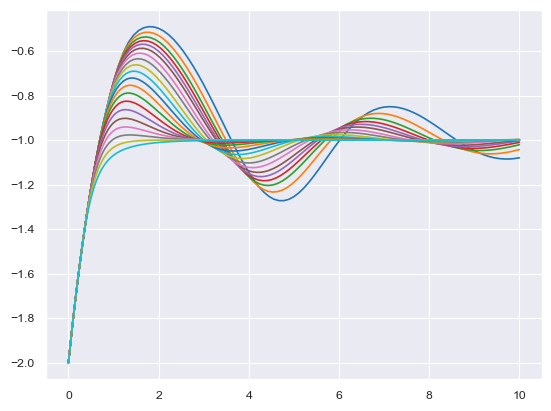

In [4]:
from    scipy               import  interpolate;



# Set up a NDDE_1D object. We will try to train the enclosed model to match the one we used to generate the above plot.
Model       = MODEL(c_0 = 1.0, c_1 = 1.0);
DDE_Module  = NDDE_1D(Model);

# Pick a starting position, tau, and x_0
tau     = torch.tensor(1.1,     requires_grad = True);
x_0     = torch.clone(x_0_True).requires_grad_(True);
T       = torch.clone(T_True).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = [tau]; #list(Model.parameters()) + [tau];
Optimizer           = torch.optim.Adam(Param_List, lr = 0.05);
N_Epochs    : int   = 20;

# Set up buffers to track history of loss, and tau.
History_Dict : Dict[str, torch.Tensor] = {};
History_Dict["Loss"]    = torch.zeros(N_Epochs);
History_Dict["tau"]     = torch.zeros(N_Epochs);

# Set up an interpolation for the true trajectory. We will need to evaluate this 
# wherever we evaluate the predicted trajectory
x_True_Interp                            = interpolate.interp1d(t_Trajectory_True.detach().numpy(), x_Trajectory_True.detach().numpy());

# Now, run the epochs!
for epoch in range(N_Epochs):    
    # find the predicted trajectories with current tau, parameter values.
    Predicted_Trajectory : torch.Tensor = DDE_Module(x_0, tau, T, x_True_Interp);

    if torch.any(torch.isnan(Predicted_Trajectory)) == False:
        # find the time steps for the output trajectory
        N : int = Predicted_Trajectory.shape[1];

        # interpolate the true solution at the new time steps. Note that we need to do 
        # this  every epoch because tau changes each epoch, and tau controls the step size.
        t_Values_np         : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N);
        Target_Trajectory   : torch.Tensor  = torch.from_numpy(x_True_Interp(t_Values_np));

        # Compute the loss!
        Loss : torch.Tensor = Loss_Fn(Predicted_Trajectory, Target_Trajectory, torch.from_numpy(t_Values_np));

        # Check if loss is low enough to stop
        if Loss < 0.001:
            print("converged after %d epochs" % epoch);
            break;

        # Otherwise, run one step of the optimizer!
        Optimizer.zero_grad();
        Loss.backward();
        Optimizer.step();

        # Report loss and stuff.
        if epoch % 1 == 0:
            print(  "%4d: "                         % epoch,
                    " Loss = %7.5f"                 % Loss.item(), 
                    " | tau = %7.5f"                % tau.item(), 
                    " | grad tau = %9.5f"           % tau.grad.item(),
                    " | Params = %7.5f, %7.5f"      % (DDE_Module.Model.Params[0], DDE_Module.Model.Params[1]), 
                    " | grad Params = %9.5f, %9.5f" % (DDE_Module.Model.Params.grad[0], DDE_Module.Model.Params.grad[1]));
            #plt.plot(Predicted_Trajectory[0].detach().numpy());

        # save the data for printing later
        History_Dict["Loss"][epoch]         = Loss.item();
        History_Dict["tau"][epoch]          = tau.item();

    else:    
        print("Something went wrong :(");
        break;

# Report final tau, parameter values.
print("Final values:");
print("tau = %7.5f, c_0 = %7.5f, c_1 = %7.5f" % (tau.item(), DDE_Module.Model.Params[0], DDE_Module.Model.Params[1]));

### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

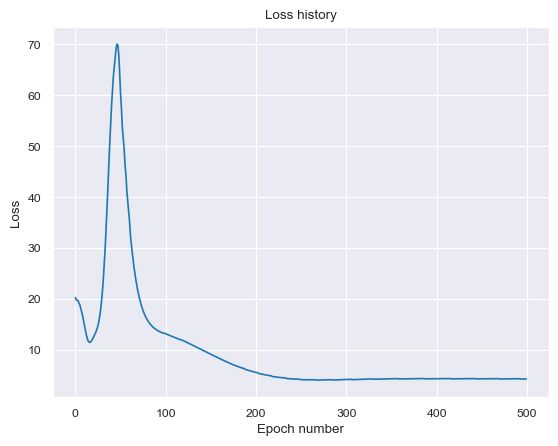

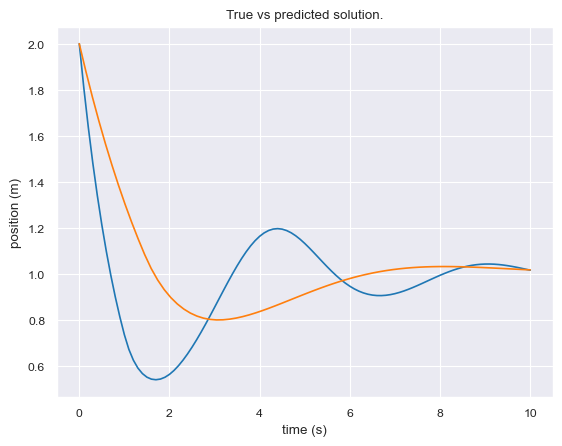

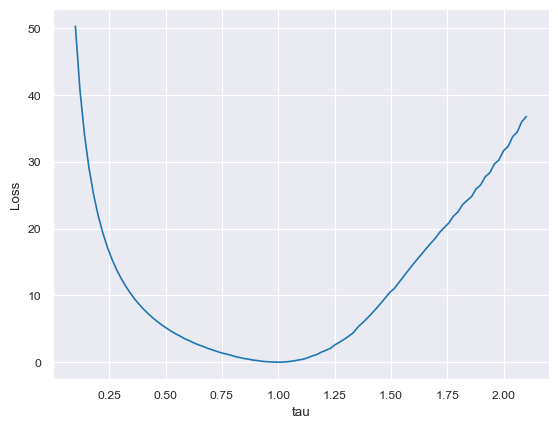

In [14]:
####################################################################################################
# Lost loss history

plt.figure(0);
plt.plot(History_Dict["Loss"].detach().numpy());
plt.xlabel("Epoch number");
plt.ylabel("Loss");
plt.title("Loss history");



####################################################################################################
# Plot true, final trajectory

plt.figure(1);
plt.plot(t_Trajectory_True, x_Trajectory_True[0].detach().numpy(),      label = "true");
plt.plot(t_Values_np,       Predicted_Trajectory[0].detach().numpy(),   label = "discovered");
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("True vs predicted solution.");



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G : MODEL = MODEL(c_0 = 1.0, c_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 100;
grid_tau = torch.linspace(0.1, 2.1, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x_0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Trajectory_True.detach().numpy(), x_Trajectory_True.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Loss_Fn(Predictions_i, Targets_i);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
plt.xlabel("tau");
plt.ylabel("Loss");